## Data 1030 : Project Code: 

##### Import data:

In [1]:
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pylab as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df= pd.read_csv('data/studentmat.csv', delimiter = ';')
print(df.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


##### G3 <10 is Fail while G3 >= 10 = Pass:

In [2]:
df['G3'] = df['G3'].map({0:'<10', 1:'<10', 2:'<10' , 3:'<10', 4:'<10', 5:'<10', 6:'<10', 7:'<10', 
                                   8:'<10',9:'<10',10:'>=10',11:'>=10', 12:'>=10',13:'>=10',14:'>=10',15:'>=10',
                                   16:'>=10',17:'>=10',18:'>=10',19:'>=10', 20:'>=10'})


##### Label Encoding on Target Variable:

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
class_values = le.fit_transform(df[['G3']])
df_class= pd.DataFrame(class_values)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
df['G3'] = df_class

#### Preparing X and y for my Machine learning Pipeline & Calculating Balance of the data:
##### Keep in mind that I have three models 
        - Model I: Includes G1, G2 
        - Model II: Includes G1
        - Model III: Does not include G1 or G2

## Model I: With G1 and G2
##### Model I:  X and y values, Balance

In [5]:
X = df.loc[:, df.columns != 'G3']
y = df['G3']

classes, counts = np.unique(y,return_counts=True)
print('balance:',np.max(counts/len(y)))
ftr_names= X.columns


balance: 0.6708860759493671


##### Model I Logistic Regression

In [6]:
###Logistic Regression parameter tuning for model I: 

def ML_pipeline_kfold_GridSearchCV_logistic(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences','G1','G2']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor, LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state = 20))

    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': np.logspace(-2,2, num=8)} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test
    

In [7]:
#print confusion_matrix(y, y_pred)
test_scores = []

for i in range(10):
    grid, test_score,feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_logistic(X,y,i*19, 5)
    print(grid.best_params_)
    print(i)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))


{'logisticregression__C': 0.13894954943731375}
0
best CV score: 0.9113924050632911
test score: 0.8607594936708861
{'logisticregression__C': 0.517947467923121}
1
best CV score: 0.9367088607594937
test score: 0.8734177215189873
{'logisticregression__C': 0.517947467923121}
2
best CV score: 0.9208860759493671
test score: 0.8860759493670886
{'logisticregression__C': 1.9306977288832496}
3
best CV score: 0.9208860759493671
test score: 0.8860759493670886
{'logisticregression__C': 0.517947467923121}
4
best CV score: 0.9272151898734177
test score: 0.8860759493670886
{'logisticregression__C': 0.517947467923121}
5
best CV score: 0.9145569620253164
test score: 0.8860759493670886
{'logisticregression__C': 0.517947467923121}
6
best CV score: 0.9430379746835443
test score: 0.9113924050632911
{'logisticregression__C': 0.517947467923121}
7
best CV score: 0.9272151898734177
test score: 0.9367088607594937
{'logisticregression__C': 0.517947467923121}
8
best CV score: 0.9208860759493671
test score: 0.873417

In [8]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_logistic(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)


0.9272151898734177
0.9367088607594937
{'logisticregression__C': 0.517947467923121}


In [9]:
import pickle
file = open('results/grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

In [10]:
import pickle
file = open('results/grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.9367088607594937
test baseline =  0.26582278481012656
shuffling school
   shuffled test score: 0.937 +/- 0.0
shuffling sex
   shuffled test score: 0.937 +/- 0.0
shuffling age
   shuffled test score: 0.927 +/- 0.008
shuffling address
   shuffled test score: 0.937 +/- 0.0
shuffling famsize
   shuffled test score: 0.937 +/- 0.0
shuffling Pstatus
   shuffled test score: 0.937 +/- 0.0
shuffling Medu
   shuffled test score: 0.937 +/- 0.0
shuffling Fedu
   shuffled test score: 0.937 +/- 0.0
shuffling Mjob
   shuffled test score: 0.937 +/- 0.0
shuffling Fjob
   shuffled test score: 0.932 +/- 0.008
shuffling reason
   shuffled test score: 0.937 +/- 0.0
shuffling guardian
   shuffled test score: 0.937 +/- 0.0
shuffling traveltime
   shuffled test score: 0.937 +/- 0.0
shuffling studytime
   shuffled test score: 0.937 +/- 0.0
shuffling failures
   shuffled test score: 0.937 +/- 0.0
shuffling schoolsup
   shuffled test score: 0.937 +/- 0.0
shuffling famsup
   shuffled test score: 0.

In [48]:
# # importances = grid.best_estimator_[1].feature_importances_[:5]
# importance = grid.best_estimator_[1].coef_[5:]
# indices = np.argsort(importances)
# features = feature_names

# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

0.9272151898734177
0.9367088607594937
{'logisticregression__C': 0.517947467923121}
[[20  1]
 [ 4 54]]
[[0.95238095 0.04761905]
 [0.06896552 0.93103448]]


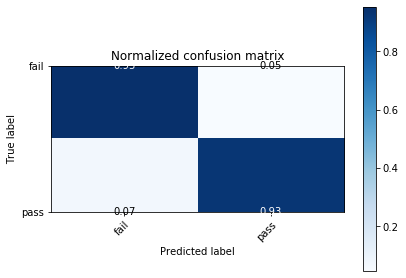

In [13]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_logistic(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(normalized_conf_mat)
plot_confusion_matrix(y_test,y_pred,classes=['fail','pass'], normalize= True)
plt.show()

#####  Random Forest Classifier

In [14]:
#Model I Random Forest Classifier
###Logistic Regression parameter tuning for model I: 


def ML_pipeline_kfold_GridSearchCV_rf(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences','G1','G2']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators =  100,random_state=random_state))

    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': range(1,30,5),
                  'randomforestclassifier__min_samples_split': range(2,20,5)} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test
    
    

In [15]:
test_scores = []
for i in range(10):
    grid, test_score, feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_rf(X,y,i*19,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'randomforestclassifier__max_depth': 16, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.9208860759493671
test score: 0.8607594936708861
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.9208860759493671
test score: 0.8481012658227848
{'randomforestclassifier__max_depth': 16, 'randomforestclassifier__min_samples_split': 12}
best CV score: 0.9335443037974683
test score: 0.8734177215189873
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.8987341772151899
test score: 0.8860759493670886
{'randomforestclassifier__max_depth': 16, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.9145569620253164
test score: 0.9113924050632911
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.930379746835443
test score: 0.8734177215189873
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_s

In [16]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_rf(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.9145569620253164
0.9367088607594937
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 17}


##### SVC:

In [17]:
#Model I SVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def ML_pipeline_kfold_GridSearchCV_svc(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences','G1','G2']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor,SVC(random_state = 20))

    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test

In [18]:
test_scores = []
for i in range(10):
    grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_svc(X,y,i*19,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.9177215189873418
test score: 0.9240506329113924
{'svc__C': 10, 'svc__gamma': 0.01}
best CV score: 0.9240506329113924
test score: 0.8987341772151899
{'svc__C': 10000, 'svc__gamma': 0.0001}
best CV score: 0.9145569620253164
test score: 0.8734177215189873
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.9208860759493671
test score: 0.8860759493670886
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.9050632911392406
test score: 0.9113924050632911
{'svc__C': 1000, 'svc__gamma': 0.0001}
best CV score: 0.9145569620253164
test score: 0.9113924050632911
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.9367088607594937
test score: 0.8481012658227848
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.9050632911392406
test score: 0.9620253164556962
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.9240506329113924
test score: 0.8607594936708861
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.8987341772151899
test sco

In [19]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_svc(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.9050632911392406
0.9620253164556962
{'svc__C': 100, 'svc__gamma': 0.001}


## Model II - With G1 without G2
##### Model II - Data prep, X and y values, Balance:

In [20]:
df1 = df.drop(['G2'], axis=1)

In [21]:
df1.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,6,5,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,4,5,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,10,7,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,1,1,5,2,15,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,1,2,5,4,6,1


X and y:

In [22]:
X = df1.loc[:, df1.columns != 'G3']
y = df1['G3']

##### Model II Logistic Regression:

In [23]:
#Model II: Logistic Regression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

###Logistic Regression parameter tuning for model I: 

def ML_pipeline_kfold_GridSearchCV_logistic(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences','G1']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor, LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state = 20))

    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': np.logspace(-2,2, num=8)} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test
    

In [24]:
test_scores = []
for i in range(10):
    grid, test_score,feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_logistic(X,y,i*19, 5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'logisticregression__C': 0.13894954943731375}
best CV score: 0.8322784810126582
test score: 0.8987341772151899
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.8544303797468354
test score: 0.8227848101265823
{'logisticregression__C': 0.517947467923121}
best CV score: 0.8670886075949367
test score: 0.7848101265822784
{'logisticregression__C': 0.517947467923121}
best CV score: 0.8607594936708861
test score: 0.759493670886076
{'logisticregression__C': 1.9306977288832496}
best CV score: 0.8512658227848101
test score: 0.8227848101265823
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.8354430379746836
test score: 0.8481012658227848
{'logisticregression__C': 0.517947467923121}
best CV score: 0.8734177215189873
test score: 0.7468354430379747
{'logisticregression__C': 1.9306977288832496}
best CV score: 0.8417721518987342
test score: 0.8481012658227848
{'logisticregression__C': 0.517947467923121}
best CV score: 0.8639240506329114
test score: 0.810126582278481
{'lo

In [25]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_logistic(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.8417721518987342
0.8481012658227848
{'logisticregression__C': 1.9306977288832496}


##### Model II: Random Forest Classifier: 

In [26]:
# Model II: Random Forest Classifier: 

def ML_pipeline_kfold_GridSearchCV_rf(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences','G1']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators =  100,random_state=random_state))

    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': range(1,30,5),
                  'randomforestclassifier__min_samples_split': range(2,20,5)} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test
    
    

In [27]:
test_scores = []
for i in range(10):
    grid, test_score,feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_rf(X,y,i*19, 5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
    
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 12}
best CV score: 0.8291139240506329
test score: 0.810126582278481
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.8354430379746836
test score: 0.8607594936708861
{'randomforestclassifier__max_depth': 16, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.8322784810126582
test score: 0.8227848101265823
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.8575949367088608
test score: 0.759493670886076
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.8069620253164557
test score: 0.8607594936708861
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.8259493670886076
test score: 0.8354430379746836
{'randomforestclassifier__max_depth': 16, 'randomforestclassifier__min_s

In [28]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_rf(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.8227848101265823
0.8354430379746836
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}


In [29]:
import pickle
file = open('results/gridm2.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

0.8227848101265823
0.8354430379746836
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}
[[16  5]
 [ 8 50]]
[[0.76190476 0.23809524]
 [0.13793103 0.86206897]]


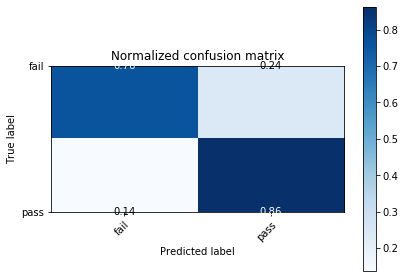

In [30]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_rf(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(normalized_conf_mat)
plot_confusion_matrix(y_test,y_pred,classes=['fail','pass'], normalize= True)
plt.show()

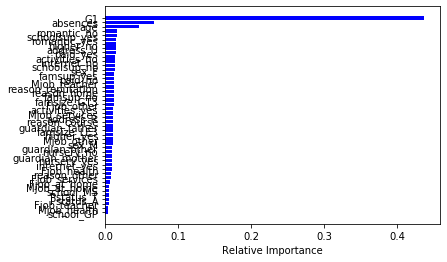

In [31]:
# importances = grid.best_estimator_[1].feature_importances_
# indices = np.argsort(importances)
# features = feature_names

# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

##### Model II: SVC 

In [32]:
#Model II SVC:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def ML_pipeline_kfold_GridSearchCV_svc(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences','G1']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor,SVC(random_state = 20))

    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test

In [33]:
test_scores = []
for i in range(10):
    grid, test_score,feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_svc(X,y,i*19, 5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'svc__C': 1, 'svc__gamma': 0.1}
best CV score: 0.8386075949367089
test score: 0.8607594936708861
{'svc__C': 1, 'svc__gamma': 0.01}
best CV score: 0.8481012658227848
test score: 0.8607594936708861
{'svc__C': 10, 'svc__gamma': 0.001}
best CV score: 0.8386075949367089
test score: 0.7088607594936709
{'svc__C': 1000, 'svc__gamma': 0.001}
best CV score: 0.8607594936708861
test score: 0.759493670886076
{'svc__C': 1000, 'svc__gamma': 0.0001}
best CV score: 0.8449367088607594
test score: 0.8354430379746836
{'svc__C': 1, 'svc__gamma': 0.01}
best CV score: 0.8164556962025317
test score: 0.8354430379746836
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.8765822784810127
test score: 0.7468354430379747
{'svc__C': 100, 'svc__gamma': 0.01}
best CV score: 0.8386075949367089
test score: 0.7974683544303798
{'svc__C': 10, 'svc__gamma': 0.001}
best CV score: 0.8322784810126582
test score: 0.8227848101265823
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.8227848101265823
test score: 0.83544303

In [34]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_svc(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.8386075949367089
0.7974683544303798
{'svc__C': 100, 'svc__gamma': 0.01}


#### Model III - No G1 & G2
##### Data prep for X and y and Balance:

In [35]:
df2 = df1.drop(['G1'], axis=1)

In [36]:
X = df2.loc[:, df2.columns != 'G3']
y = df2['G3']

##### Model III - Logistic Regression 

In [37]:
##### Model III - Logistic Regression 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer


def ML_pipeline_kfold_GridSearchCV_logistic(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor, LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state = 20))

    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': np.logspace(-2,2, num=8)} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test
    

In [38]:
### feature imp
def ML_pipeline_kfold_LR2(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
#     ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
#                     'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
      
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])
    
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler, LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.8s finished


test score: 0.7468354430379747


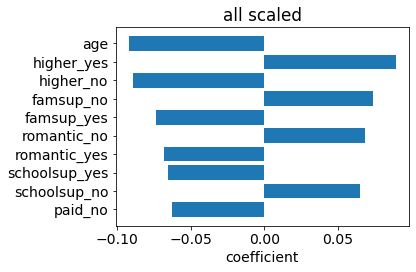

In [39]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR2(X,y,7*19,5)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
plt.show()

In [40]:
test_scores = []
for i in range(10):
    grid, test_score,feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_logistic(X,y,i*19, 5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'logisticregression__C': 0.13894954943731375}
best CV score: 0.6867088607594937
test score: 0.6329113924050633
{'logisticregression__C': 0.01}
best CV score: 0.6582278481012658
test score: 0.7215189873417721
{'logisticregression__C': 0.517947467923121}
best CV score: 0.689873417721519
test score: 0.5569620253164557
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.6740506329113924
test score: 0.6708860759493671
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.6740506329113924
test score: 0.6835443037974683
{'logisticregression__C': 1.9306977288832496}
best CV score: 0.6677215189873418
test score: 0.7215189873417721
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.6582278481012658
test score: 0.7341772151898734
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.6582278481012658
test score: 0.7341772151898734
{'logisticregression__C': 0.13894954943731375}
best CV score: 0.6772151898734177
test score: 0.6708860759493671
{'logisticr

In [41]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_logistic(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.6582278481012658
0.7341772151898734
{'logisticregression__C': 0.13894954943731375}


##### Model III RFC

In [42]:
# Model III: Random Forest Classifier: 

def ML_pipeline_kfold_GridSearchCV_rf(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators =  100,random_state=random_state))

    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': range(1,30,5),
                  'randomforestclassifier__min_samples_split': range(2,20,5)} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test
    
    

In [43]:
test_scores = []
for i in range(10):
    grid, test_score, feature_name, X_test, y_test = ML_pipeline_kfold_GridSearchCV_rf(X,y,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.6835443037974683
test score: 0.620253164556962
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.6930379746835443
test score: 0.620253164556962
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__min_samples_split': 7}
best CV score: 0.6677215189873418
test score: 0.6962025316455697
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.680379746835443
test score: 0.6708860759493671
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.6487341772151899
test score: 0.759493670886076
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.6645569620253164
test score: 0.6962025316455697
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_

In [44]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_rf(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.6550632911392406
0.7341772151898734
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__min_samples_split': 2}


#### Model III SVC

In [45]:
#Model II SVC:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
def ML_pipeline_kfold_GridSearchCV_svc(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    cat_ftrs = ['school','sex','address','Pstatus','famsize','schoolsup','famsup','paid','activities','nursery',
                    'Mjob', 'Fjob','reason', 'guardian', 'higher', 'internet', 'romantic']
    ordinal_ftrs = ['Medu', 'Fedu', 'health','freetime', 'goout','famrel' 'Dalc', 'Walc', 
                'traveltime','studytime', 'failures'] #already pre processd
    num_ftrs = ['age','absences']
    label = ['G3']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])

    pipe = make_pipeline(preprocessor,SVC(random_state = 20))

    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    
    feature_names = num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test), np.array(feature_names), X_test, y_test

In [46]:
test_scores = []
for i in range(10):
    grid, test_score, feature_names, X_test, y_test = ML_pipeline_kfold_GridSearchCV_svc(X,y,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.mean(test_scores),'+/-',np.std(test_scores))

{'svc__C': 10, 'svc__gamma': 0.01}
best CV score: 0.6867088607594937
test score: 0.6329113924050633
{'svc__C': 100, 'svc__gamma': 0.001}
best CV score: 0.6867088607594937
test score: 0.6329113924050633
{'svc__C': 0.001, 'svc__gamma': 1e-05}
best CV score: 0.6645569620253164
test score: 0.6962025316455697
{'svc__C': 0.001, 'svc__gamma': 1e-05}
best CV score: 0.6772151898734177
test score: 0.6455696202531646
{'svc__C': 1, 'svc__gamma': 1}
best CV score: 0.6550632911392406
test score: 0.759493670886076
{'svc__C': 1, 'svc__gamma': 1}
best CV score: 0.6677215189873418
test score: 0.6962025316455697
{'svc__C': 0.001, 'svc__gamma': 1e-05}
best CV score: 0.6613924050632911
test score: 0.7088607594936709
{'svc__C': 0.001, 'svc__gamma': 1e-05}
best CV score: 0.7025316455696202
test score: 0.5443037974683544
{'svc__C': 1, 'svc__gamma': 1}
best CV score: 0.6645569620253164
test score: 0.7088607594936709
{'svc__C': 0.001, 'svc__gamma': 1e-05}
best CV score: 0.6550632911392406
test score: 0.73417721

In [47]:
grid, test_score, feature_names, X_test, y_test= ML_pipeline_kfold_GridSearchCV_svc(X,y,7*19,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.6582278481012658
0.7215189873417721
{'svc__C': 1, 'svc__gamma': 1}
